<a href="https://colab.research.google.com/github/zfurman56/toy-modularity/blob/main/Toy_modularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import plotly.graph_objs as go
from scipy.interpolate import interpn
import networkx as nx

In [219]:
class MultiDimensionalInterpolator:
    def __init__(self, lookup_table, method='linear'):
        """
        Initialize the MultiDimensionalInterpolator with a lookup table.
        
        Args:
        lookup_table (np.ndarray): An n-dimensional lookup table with an additional output dimension.
        """
        self.lookup_table = lookup_table
        self.dimensions = lookup_table.shape[:-1]
        self.grid = [np.linspace(0, 1, dim) for dim in self.dimensions]
        self.method = method

    def interpolate(self, coordinates):
        """
        Interpolates values in the lookup table using linear interpolation.
        
        Args:
        coordinates (list or np.ndarray): A list or array of coordinates to be interpolated, where each
                                          coordinate is a tuple of length n. Can also be a single coordinate.
                                          
        Returns:
        np.ndarray: An array of interpolated values.
        """
        # Ensure coordinates are in a NumPy array and at least 2D
        coordinates = np.atleast_2d(coordinates)

        # Initialize an array to store the interpolated output vectors
        output_shape = (len(coordinates), self.lookup_table.shape[-1])
        interpolated_values = np.empty(output_shape)

        # Perform interpolation for each component of the output vector
        for i in range(self.lookup_table.shape[-1]):
            interpolated_values[:, i] = interpn(self.grid, self.lookup_table[..., i], coordinates, method=self.method)

        return interpolated_values

# Example usage
lookup_table = np.random.rand(4, 5, 6, 3)  # 3D lookup table with 3D output vectors
interpolator = MultiDimensionalInterpolator(lookup_table)

# Single coordinate
single_coordinate = [(0.5, 0.7, 0.2)]
result_single = interpolator.interpolate(single_coordinate)
print(result_single)

# List of coordinates
coordinates_list = [(0.5, 0.7, 0.2), (0.3, 0.8, 0.6)]
result_list = interpolator.interpolate(coordinates_list)
print(result_list)

[[0.61414877 0.46213939 0.09856587]]
[[0.61414877 0.46213939 0.09856587]
 [0.32525825 0.38618947 0.46543634]]


In [233]:
# Define the lookup table for a 2D input and 1D output.
lookup_table = np.array([
    [[0.1], [0.2], [0.2], [0.3]],
    [[0.1], [0.2], [0.3], [0.2]],
    [[0.2], [0.2], [0.1], [0.2]],
    [[0.2], [0.2], [0.2], [0.2]]
])

# Generate a grid of coordinates to evaluate the interpolation function.
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x, y)
coordinates = np.vstack((xx.ravel(), yy.ravel())).T

# Evaluate the interpolation function at the generated coordinates.
interpolator = MultiDimensionalInterpolator(lookup_table)
interpolated_values = interpolator.interpolate(coordinates)
zz = interpolated_values.reshape(xx.shape)

# Create a 3D surface plot using Plotly.
surface = go.Surface(x=xx, y=yy, z=zz)
data = [surface]

layout = go.Layout(
    title="Test Plot",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Interpolated Value",
    ),
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [186]:
class FunctionGraphEvaluator:
    def __init__(self, graph):
        """
        Initialize the FunctionGraphEvaluator with a networkx directed acyclic graph.
        
        Args:
        graph (networkx.DiGraph): A directed acyclic graph where nodes represent function instances
                                  and edge attributes contain input-output connections.
        """
        self.graph = graph

    def evaluate(self, coordinates):
        """
        Evaluates the functions using the hierarchical structure defined by the graph.
        
        Args:
        coordinates (list or np.ndarray): A list or array of coordinates to be processed.
        
        Returns:
        np.ndarray: An array of merged output values.
        """
        # Ensure coordinates are in a NumPy array
        coordinates = np.atleast_2d(coordinates)

        # Initialize a dictionary to store the output values
        output_values = {}

        # Calculate the output values
        for node in nx.topological_sort(self.graph):
            if node == 'input':
                output_values[node] = coordinates
            else:
                predecessors = list(self.graph.predecessors(node))
                input_data = []

                for p in predecessors:
                    for output_index, input_index in self.graph.edges[p, node]['connections']:
                        input_data.append(output_values[p][:, output_index].reshape(-1, 1))
                inputs = np.hstack(input_data)

                if node == 'output':
                    output_values[node] = inputs
                else:
                    function = self.graph.nodes[node]['function']
                    output_values[node] = np.atleast_2d(function(inputs))

        return output_values['output']


# Create a directed acyclic graph
graph = nx.DiGraph()

# Add unique input and output nodes
graph.add_node('input')
graph.add_node('output')

# Add nodes with MultiDimensionalInterpolator instances and input dimensions
graph.add_node(42, function=MultiDimensionalInterpolator(np.random.rand(4, 5, 1)).interpolate)
graph.add_node(0, function=MultiDimensionalInterpolator(np.random.rand(6, 2)).interpolate)
graph.add_node(1, function=MultiDimensionalInterpolator(np.random.rand(3, 4, 5, 2)).interpolate)
graph.add_node(2, function=MultiDimensionalInterpolator(np.random.rand(2, 4, 1)).interpolate)

# Add edges to define the connections between functions
# (source_output_index, target_input_index) tuples define the individual connections
graph.add_edge('input', 42, connections=[(0, 0), (2, 1)])
graph.add_edge('input', 0, connections=[(1, 0)])
graph.add_edge(42, 1, connections=[(0, 2)])
graph.add_edge(0, 1, connections=[(1, 1), (1, 0)])
graph.add_edge(1, 2, connections=[(0, 0), (1, 1)])
graph.add_edge(2, 'output', connections=[(0, 0), (0, 1)])

# Create the FunctionGraphEvaluator
fgraph = FunctionGraphEvaluator(graph)
coordinates = [(0.2, 0.4, 0.3), (0.5, 0.7, 0.2)]  # List of 3D coordinates
#coordinates = [(0.5, 0.7, 0.2)]  # List of 3D coordinates
result = fgraph.evaluate(coordinates)

print(result)



[[0.20721651 0.20721651]
 [0.39680847 0.39680847]]


In [192]:
# Define polynomial functions for each node
def poly1(x):
    # f(x) = x^2 + 2x + 3
    return x**2 + 2*x + 3

def poly2(x):
    # f(x) = 3x^2 - x + 1
    return 3*x**2 - x + 1

def poly3(x, y):
    # f(x) = 2x^2 + x - 2
    return 2*x**2 + y - 2

def wrap(func):
    def ufunc(inputs):
        return func(*inputs.T)[:, np.newaxis]
    return ufunc

# Create a directed acyclic graph
graph = nx.DiGraph()

# Add unique input and output nodes
graph.add_node('input')
graph.add_node('output')

# Add nodes with polynomial functions
graph.add_node(0, function=poly1)
graph.add_node(1, function=poly2)
graph.add_node(2, function=wrap(poly3))

# Add edges to define the connections between functions
graph.add_edge('input', 0, connections=[(0, 0)])
graph.add_edge('input', 1, connections=[(1, 0)])
graph.add_edge(0, 2, connections=[(0, 0)])
graph.add_edge(1, 2, connections=[(0, 1)])
graph.add_edge(2, 'output', connections=[(0, 0)])

# Create the FunctionGraphEvaluator
function_graph_evaluator = FunctionGraphEvaluator(graph)

# Define test inputs
test_inputs = np.array([[1, 2], [-1, 3], [0, -2], [2, 1]])

# Evaluate the functions using the graph structure
outputs = function_graph_evaluator.evaluate(test_inputs)

# Calculate expected outputs
expected_outputs = poly3(poly1(test_inputs[:, 0]), poly2(test_inputs[:, 1]))

# Verify if the outputs match the expected outputs
assert np.allclose(outputs.T[0], expected_outputs), "The outputs do not match the expected outputs."

print("Test passed! The outputs match the expected outputs.")


Test passed! The outputs match the expected outputs.


In [236]:
def random_interpolator(input_dim, output_dim, resolution=4, method='linear'):
    table_dims = ([resolution] * input_dim) + [output_dim]
    return MultiDimensionalInterpolator(np.random.random(table_dims), method)

# Create random function graph with Erdös-Rényi topology and interpolating nodes
def random_function_graph(num_nodes, input_dim, output_dim, density=0.5, arity=3):
    # Create random (potentially cyclic) directed graph
    G = nx.gnp_random_graph(num_nodes, density, directed=True)

    # Make the graph a DAG by pruning edges
    graph = nx.DiGraph([(u, v) for (u, v) in G.edges() if u < v])

    # Add the interpolators
    for node in nx.topological_sort(graph):
        # Prune incoming edges if they exceed arity
        if len(graph.in_edges(node)) > arity:
            edges_to_remove = random.sample(list(graph.in_edges(node)), len(graph.in_edges(node)) - arity)
            graph.remove_edges_from(edges_to_remove)

        graph.nodes[node]['input_size'] = arity
        graph.nodes[node]['output_size'] = arity
        graph.nodes[node]['function'] = random_interpolator(arity, arity).interpolate
    
    # Find the source and sink nodes, and connect them to the input/output
    # node, respectively
    source_nodes = [n for n, d in graph.in_degree() if d == 0]
    sink_nodes = [n for n, d in graph.out_degree() if d == 0]

    # Prune excess sink nodes and (unneeded) ancestors when we can't actually
    # connect them to the output because output_dim is too low
    while len(sink_nodes) > output_dim:
        # Select a random sink node to remove
        node_to_remove = random.choice(sink_nodes)
        
        # Find unnecessary ancestors of the node to remove
        ancestors = nx.ancestors(graph, node_to_remove)
        nodes_to_remove = [ancestor for ancestor in ancestors if graph.out_degree(ancestor) == 0]
        
        # Remove the selected sink node and its unnecessary ancestors from the graph
        nodes_to_remove.append(node_to_remove)
        graph.remove_nodes_from(nodes_to_remove)
        
        # Update the list of sink nodes
        sink_nodes = [n for n, d in graph.out_degree() if d == 0]

    graph.add_node('input')
    graph.add_node('output')
    graph.nodes['input']['output_size'] = input_dim
    graph.nodes['output']['input_size'] = output_dim

    for source in source_nodes:
        graph.add_edge('input', source)
    for sink in sink_nodes:
        graph.add_edge(sink, 'output')
    
    # Connect functions together by looping through the incoming edges
    # for each node, and setting `connections` so that each incoming node has at
    # one of its outputs connected to at least one of the inputs for the current node
    for node in graph.nodes:
        if node not in ['input']:
            input_connections = list(range(graph.nodes[node]['input_size']))
            predecessors = list(graph.predecessors(node))

            # Initialize connection lists for each predecessor
            connection_lists = {p: [] for p in predecessors}

            # Round-robin assignment of input connections
            for i, input_index in enumerate(input_connections):
                p = predecessors[i % len(predecessors)]
                output_index = graph.nodes[p]['output_size'] - 1 - i % graph.nodes[p]['output_size']
                connection_lists[p].append((output_index, input_index))

            # Assign connections to graph edges
            for p in predecessors:
                graph.edges[p, node]['connections'] = connection_lists[p]
      
    return FunctionGraphEvaluator(graph)


32

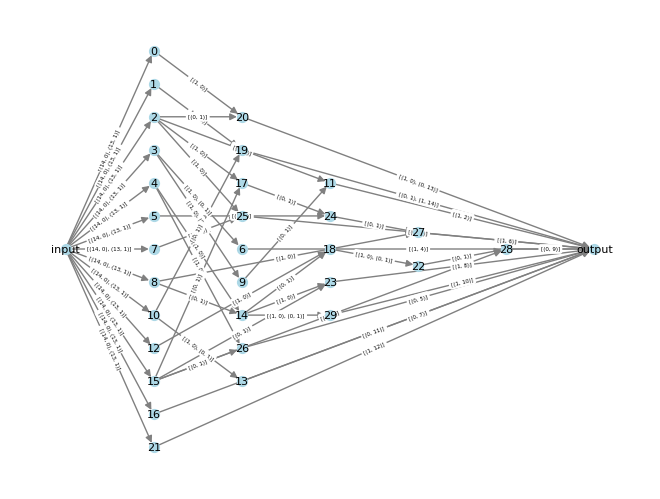

In [286]:
fg = random_function_graph(30, 15, 15, arity=2, density=0.1)
G = fg.graph

for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")

# Draw the nodes and edges
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=50, font_size=8)

# Get edge labels based on the 'weight' attribute
edge_labels = nx.get_edge_attributes(G, 'connections')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=4)

len(G.nodes)

In [239]:
# Generate a grid of coordinates to evaluate the interpolation function.
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x, y)
coordinates = np.vstack((xx.ravel(), yy.ravel())).T

interpolated_values = fg.evaluate(coordinates)
zz = interpolated_values.reshape(xx.shape)

# Create a 3D surface plot using Plotly.
surface = go.Surface(x=xx, y=yy, z=zz)
data = [surface]

layout = go.Layout(
    title="Test Plot",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Interpolated Value",
    ),
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [266]:
class Hat(nn.Module):
  def __init__(self, scale=1):
    super(Hat, self).__init__()
    self.scale = scale
  
  def forward(self, x):
    x = x * self.scale
    return ((x > 0) * x) + ((x > 1) * 2 * (1 - x)) + ((x > 2) * (x - 2))

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers):
        super(FeedForwardNN, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [293]:
input_size = 15
hidden_size = 64
output_size = 15
hidden_layers = 10

# Generate training data
num_samples = 1000
coordinates = np.random.rand(num_samples, input_size)  # Change the 2 to the number of input dimensions

# Create a FunctionGraphEvaluator instance
graph_evaluator = fg

# Calculate the output values for the training data
output_values = graph_evaluator.evaluate(coordinates)

# Split the data into training and validation sets
train_split = int(0.8 * num_samples)
train_x = torch.tensor(coordinates[:train_split], dtype=torch.float32)
train_y = torch.tensor(output_values[:train_split], dtype=torch.float32)
val_x = torch.tensor(coordinates[train_split:], dtype=torch.float32)
val_y = torch.tensor(output_values[train_split:], dtype=torch.float32)

batch_size = 64

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [294]:
model = FeedForwardNN(input_size, hidden_size, output_size, hidden_layers)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

    if (epoch % 100) == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch: 1/1000, Train Loss: 0.2476, Validation Loss: 0.2105
Epoch: 101/1000, Train Loss: 0.0122, Validation Loss: 0.0150
Epoch: 201/1000, Train Loss: 0.0025, Validation Loss: 0.0048
Epoch: 301/1000, Train Loss: 0.0016, Validation Loss: 0.0034
Epoch: 401/1000, Train Loss: 0.0010, Validation Loss: 0.0027
Epoch: 501/1000, Train Loss: 0.0009, Validation Loss: 0.0023
Epoch: 601/1000, Train Loss: 0.0006, Validation Loss: 0.0021
Epoch: 701/1000, Train Loss: 0.0006, Validation Loss: 0.0021
Epoch: 801/1000, Train Loss: 0.0008, Validation Loss: 0.0021
Epoch: 901/1000, Train Loss: 0.0005, Validation Loss: 0.0021


In [269]:
test_coordinates = np.random.rand(5, input_size)
test_x = torch.tensor(test_coordinates, dtype=torch.float32)

with torch.no_grad():
    model.eval()
    test_output = model(test_x)

print("True output:", fg.evaluate(test_coordinates))
print("Test output:", test_output.numpy())

True output: [[0.23577264 0.23577264 0.51309033 0.51309033 0.53000547 0.53000547
  0.67093455 0.67093455 0.19954069 0.50875275]
 [0.29015385 0.29015385 0.70898463 0.70898463 0.51882741 0.51882741
  0.54897212 0.54897212 0.34676606 0.35509897]
 [0.27464648 0.27464648 0.71693799 0.71693799 0.62778635 0.62778635
  0.42742371 0.42742371 0.13877906 0.38577403]
 [0.22212985 0.22212985 0.46036485 0.46036485 0.45942585 0.45942585
  0.62797415 0.62797415 0.32376217 0.50473209]
 [0.22064248 0.22064248 0.51714139 0.51714139 0.38091517 0.38091517
  0.46917309 0.46917309 0.49326359 0.54348825]]
Test output: [[0.21607047 0.213764   0.5297371  0.5294358  0.52864546 0.53104055
  0.6514735  0.65044373 0.18401979 0.50707746]
 [0.2759623  0.2727104  0.7219609  0.72031957 0.5874385  0.5875419
  0.5692755  0.56827086 0.33842388 0.3713052 ]
 [0.27974105 0.27817804 0.7211651  0.7205557  0.61638105 0.6180906
  0.44886392 0.4473874  0.1596537  0.40461674]
 [0.19912642 0.20047878 0.48990455 0.48830852 0.4730937

In [248]:
import numpy as np
import plotly.graph_objs as go
import torch

# Generate a grid of coordinates to evaluate the interpolation function.
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x, y)
coordinates = np.vstack((xx.ravel(), yy.ravel())).T

# Make sure your model is in evaluation mode and transfer to device (if necessary).
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert coordinates to PyTorch tensors and evaluate the model.
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
with torch.no_grad():
    interpolated_values = model(coordinates_tensor)

# Convert the result back to NumPy and reshape.
zz = interpolated_values.cpu().numpy().reshape(xx.shape)

# Create a 3D surface plot using Plotly.
surface = go.Surface(x=xx, y=yy, z=zz)
data = [surface]

layout = go.Layout(
    title="Test Plot",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Interpolated Value",
    ),
)

fig = go.Figure(data=data, layout=layout)
fig.show()
